# `GenericSeries` Tutorial

## Introduction

The `GenericSeries` class describes a potentially multi-dimensional quantity that depends on one or more dimensions.
Some examples are the position of the welding torch that depends on time or the workpiece temperature field that depends on time and space.
The data of the `GenericSeries` can either be stored in form of explicit values or as a mathematical expression.
It's main feature is that you can evaluate the data at any given coordinate of the dimensions it depends on.
This happens either through interpolation if the data is discrete or through direct evaluation of the mathematical expression.
We can use the `GenericSeries` in our scripts and jupyter notebooks by importing it from the WelDX python package:

In [25]:
from weldx import GenericSeries

For this tutorial, we will also need to import the following packages and classes:

In [26]:
from weldx import Q_
from xarray import DataArray

import matplotlib.pyplot as plt
import numpy as np

## Terminology

Before we can start with the actual tutorial, we need to discuss some terminology.
It is essential to understand the differences between the following terms to avoid confusion throughout the course of this tutorial.

**Dimension**

Each dimension describes a single degree of freedom. 
We can think of it as a 1d-coordinate axis. 
Using multiple dimensions will create a multi-dimensional space. 
A typical example would be the dimensions $x$, $y$, and $z$ that form 3d-space. 
Another popular dimension is time.

**Coordinates**

A coordinate is a specific value or label on the 1d-axis of a dimension. 
We can specify the location of a point in 3d-space by providing its coordinates. 
For example, we can use $x=1m$, $y=3m$, and $z=0m$.
These are coordinates for the dimensions $x$, $y$, and $z$.
Dimensions represent degrees of freedom, coordinates are discrete values of a dimension.

**Variable**

If a mathematical expression is used to describe the `GenericSeries`, the individual terms of this expression can be divided into two groups. 
The first group are variables. 
Variables are symbols that don't get values assigned to them during the creation of a `GenericSeries`.
They let us evaluate the expression for differen coordinates.
Consider the following expression:

$$
2 \cdot x + 3
$$

Here, $x$ is our variable. 
We can evaluate this expression over and over again by providing differen values/coordinates for $x$.
For example, if we would use $x=2$, the result is $7$. 
With $x=4$ we would get $11$. 
An important fact to note is that each variable of a `GenericSeries`' expression is a dimension. 
But not every dimension of an expression is necessarily represented by a variable.
We will show some code examples later that make this more understandable.

**Parameter**

The second group of therms in an expression based `GenericSeries` are parameters.
Parameters are also symbols of an expression, but in contrast to variables, they already get discrete values assigned to them.
Consider the following expression:

$$
a \cdot t + b
$$

with:

$$
\begin{matrix}
a=&3m/s\\
b=&5m
\end{matrix}
$$

$a$ and $b$ are parameters, because they have values assigned to them. 
`t` is still a variable

## Discrete data

### Construction

As mentioned in the introduction, the `GenericSeries` can either describe a dimension dependent quantity by a set of discrete values or a mathematical expression.
We will start this tutorial with discrete values.

Let's say we we want to describe the temperature of a specimen along our welding groove during a single pass welding experiment.
The spatial direction along the groove is the dimension `x`.
Time is represented by the dimension `t`.
We have measured the temparature at 4 differrent points in time and at 6 different positions.
Our data measured in Kelvin is:

In [27]:
t_0 = [300, 300, 300, 300, 300, 300]
t_1 = [800, 1200, 400, 300, 300, 300]
t_2 = [450, 500, 600, 800, 1200, 400]
t_3 = [412, 425, 450, 500, 600, 800]

data = Q_([t_0, t_1, t_2, t_3], "K")

We also know the coordinates of the data in `x` and `t`:

In [28]:
coords_t = Q_([0, 10, 20, 30], "s")
coords_x = Q_([0, 5, 10, 15, 20, 25], "cm")

Here is a quick plot of our temperature data:

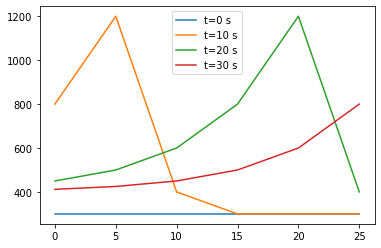

In [29]:
plt.plot(
    coords_x.m, np.transpose(data.m),
    label=[f"t={v}" for v in coords_t]
)
plt.gca().legend()

Now we can create our `GenericSeries` an follows:

In [30]:
gs_discrete = GenericSeries(
    data=data, 
    dims=["t", "x"], 
    coords={"t":coords_t, "x":coords_x}
)
gs_discrete

<GenericSeries>
Values:
[[ 300  300  300  300  300  300]
 [ 800 1200  400  300  300  300]
 [ 450  500  600  800 1200  400]
 [ 412  425  450  500  600  800]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int32 0 10 20 30
  * x        (x) int32 0 5 10 15 20 25
Units:
	K

> TODO: Check and update discret __repr__ -> do not print all values, don't print Coordinates twice

The first argument is the raw data.
`dims` expects a list of strings that we can use to give our dimensions names.
With `coords` we provide the coordinates of our discrete values.
`dims` and `coords` are optional.
If you don't provide dimension names, the `GenericSeries` will use default names:

In [31]:
GenericSeries(data=data).dims

('dim_0', 'dim_1')

If you are already familiar with the `xarray` python package, you might have noticed the similarities between the construction of a `GenericSeries` and an `xarray.DataArray`.
In fact, the discrete version of the `GenericSeries` is based on an `xarray.DataArray` and they share some interfaces with comparable behavior.

### Accessing data

If you want to access a single item you can use the `[]` operator to select elemets by index:

In [32]:
gs_discrete[3,4]

<xarray.DataArray ()>
<Quantity(600, 'kelvin')>
Coordinates:
    t        int32 30
    x        int32 20

Slicing is also possible:

In [33]:
gs_discrete[2:4,:]

Magnitude,[[ 450 500 600 800 1200 400] [ 412 425 450 500 600 800]]
Units,K


> TODO: implement and demonstrate sel function like in xarray

## Evaluation/Interpolation

Even though the `GenericSeries` might be based on discrete values, you should think of it as some kind of mathematical function object that can be evaluated at any coordinate along its dimensions.
To do so, we simply use the call operator `()` on our `GenericSeries` and specify the coordinates we are interested in.
For example, we might be interested in the temperature at $x=12cm$ and $t=24s$.
The coordinates are passed as keyword arguments where the key is the dimension and the value are the coordinates we are interested in:

> **TODO: Really IMPORTANT** -> We need to assure that the units at the coordinates are used correctly. Currently only the magnitude is taken. So using "nm" or "m" instead of "cm" has no effect on the result. I could even use a totally unrelated unit without any problems


In [37]:
gs_discrete(t="24s", x="12cm")

<GenericSeries>
Values:
[[596.]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 24
  * x        (x) int64 12
Units:
	K

It is not necessary to provide coordinates for all dimensions.
A single dimension is already enough:

In [35]:
gs_discrete(t="24s")

<GenericSeries>
Values:
[[434.8 470.  540.  680.  960.  560. ]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 24
  * x        (x) int64 0 5 10 15 20 25
Units:
	K

Of cause, we can also evaluate multiple coordinate values for each dimension:

In [41]:
gs_discrete(t=Q_([11, 23], "s"), x=Q_([3, 14, 22], "cm"))

<GenericSeries>
Values:
[[984.   364.   358.  ]
 [461.94 679.   820.  ]]
Dimensions:
	('t', 'x')
Coordinates:
	Coordinates:
  * t        (t) int64 11 23
  * x        (x) int64 3 14 22
Units:
	K

You may have noticed that we exclusively used coordinate values that do not match the coordinates we initially provided to the `GenericSeries`.
The actual data values are obtained by interpolation.
By default, the `GenericSeries` uses linear interpolation.

In [11]:
from weldx.core import GenericSeries, MathematicalExpression, Q_

In [12]:
expr = "a*t + b"

In [13]:
me=MathematicalExpression(expr, parameters={"a":(Q_([10, 1, 1],"m/s"),"c"), "b":(Q_([1,2,3],"m"), "d")})

In [14]:
gs=GenericSeries(me,units={"t":"s"})

In [15]:
gs(dict(t=Q_("3s")))

TypeError: __call__() takes 1 positional argument but 2 were given